<pre style="text-align: right; width: 100%; font-size: 0.75em; line-height: 0.75em;">
+ ------------------------- + <br>
| 20/04/2025                | <br>
| Héctor Tablero Díaz       | <br>
| Álvaro Martínez Gamo      | <br>
+ ------------------------- + 
</pre>

# **Noise Schedulers**

In [ ]:
import sys
sys.path.append('./..')

import os

import torch
from torch.utils.data import Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

from image_gen import GenerativeModel
from image_gen.samplers import EulerMaruyama
from image_gen.diffusion import VariancePreserving
from image_gen.noise import LinearNoiseSchedule, CosineNoiseSchedule

import matplotlib.pyplot as plt
from IPython.display import HTML
from image_gen.visualization import display_images, create_evolution_widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **Schedule Visualization**

The schedules determine how much noise will be added over time. We can preview their impact by plotting the result of their `__call__` method:

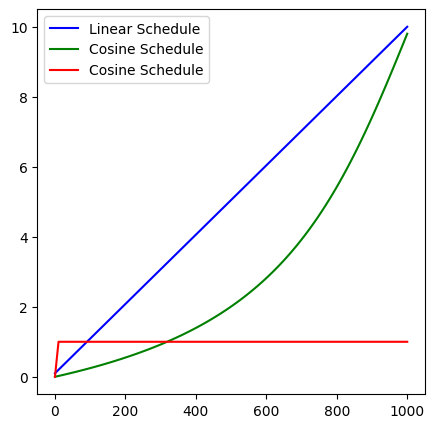

In [ ]:
max_t = 1000.0
beta_max = 10.0
x = torch.linspace(0, max_t, 100)

plt.figure(figsize=(5, 5))

lin_schedule = LinearNoiseSchedule(max_t=max_t, beta_max=beta_max)
plt.plot(x, lin_schedule(x), label='Linear Schedule', color='blue')

cos_schedule = CosineNoiseSchedule(max_t=max_t, beta_max=beta_max)
plt.plot(x, cos_schedule(x), label='Cosine Schedule', color='green')

plt.legend()
plt.show()

### **Image Generation**

Noise schedules are compatible with the default classes of `VariancePreserving` and `SubVariancePreserving`.

We can see how the schedules affect the results by training a model with each, and running them with the same seed:

In [24]:
# Set up the common variables
epochs = 50
digit = 3

seed = 42

In [25]:
# Load the dataset
data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

# Select a subset to speed up the training process
indices_digit = torch.where(data.targets == digit)[0]
data = Subset(data, indices_digit)

**Linear:**

In [ ]:
model = GenerativeModel(
    diffusion=VariancePreserving,
    sampler=EulerMaruyama,
    noise_schedule=LinearNoiseSchedule
)

In [ ]:
filename = f'saved_models/mnist_{digit}_vp-lin_euler_{epochs}e.pth'

if os.path.isfile(filename):
    model.load(filename)
else:
    model.train(data, epochs=epochs)
    # Tip: Save the models for them to be accessible through the dashboard
    model.save(filename)

Generating:   0%|          | 0/500 [00:00<?, ?it/s]

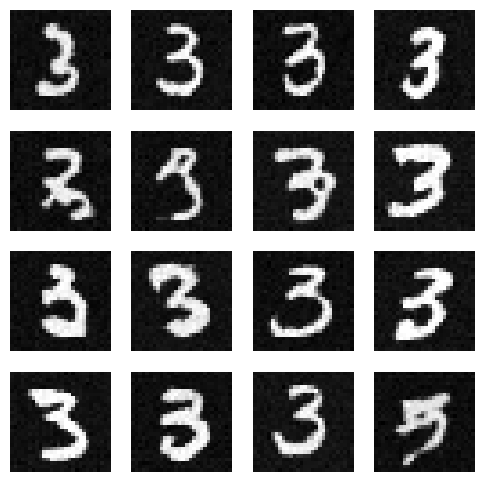

In [27]:
n_images = 16
samples = model.generate(n_images, seed=seed)
display_images(samples)

In [69]:
HTML(create_evolution_widget(model, seed=seed).to_jshtml(default_mode="once"))

Generating:   0%|          | 0/500 [00:00<?, ?it/s]

**Cosine:**

In [ ]:
model = GenerativeModel(
    diffusion=VariancePreserving,
    sampler=EulerMaruyama,
    noise_schedule=CosineNoiseSchedule
)

c:\Users\hecto\Desktop\Uni\AAUTO 3\Proyecto\examples\..\image_gen\base.py:84: UserWarning: VariancePreserving does not require a noise schedule. The provided noise schedule will be ignored.
  warnings.warn(


In [ ]:
filename = f'saved_models/mnist_{digit}_vp-cos_euler_{epochs}e.pth'

if os.path.isfile(filename):
    model.load(filename)
else:
    model.train(data, epochs=epochs)
    # Tip: Save the models for them to be accessible through the dashboard
    model.save(filename)

Generating:   0%|          | 0/500 [00:00<?, ?it/s]

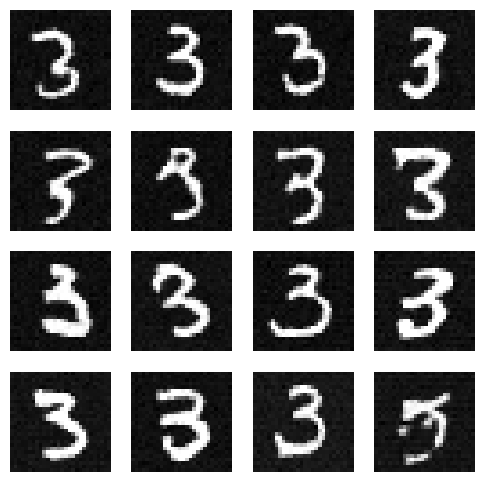

In [13]:
n_images = 16
samples = model.generate(n_images, seed=seed)
display_images(samples)

Generating:   0%|          | 0/500 [00:00<?, ?it/s]

<IPython.core.display.HTML object>


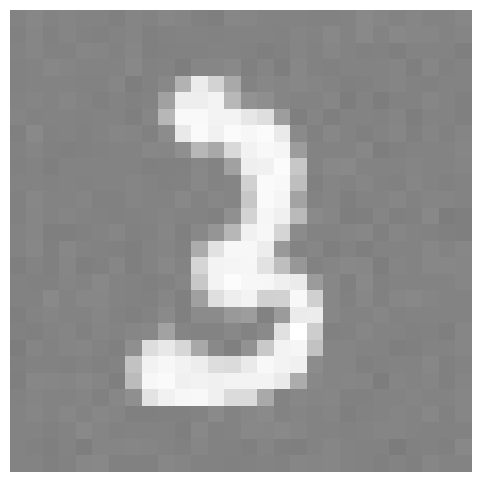

In [ ]:
HTML(create_evolution_widget(model, seed=seed).to_jshtml(default_mode="once"))

### **Default Schedule Recommendations**

The `GenerativeModel` class can also receive an initialized noise scheduler class.

This can be used to change the outcome of the generation:

In [15]:
model = GenerativeModel(
    diffusion=VariancePreserving,
    sampler=EulerMaruyama,
    noise_schedule=LinearNoiseSchedule(max_t=1000.0, beta_min=0.0001, beta_max=20.0)
)

c:\Users\hecto\Desktop\Uni\AAUTO 3\Proyecto\examples\..\image_gen\base.py:84: UserWarning: VariancePreserving does not require a noise schedule. The provided noise schedule will be ignored.
  warnings.warn(


In [16]:
model = GenerativeModel(
    diffusion=VariancePreserving,
    sampler=EulerMaruyama,
    noise_schedule=CosineNoiseSchedule(max_t=1000.0, s=0.008, beta_max=20.0)
)

Where:
- `max_t` is duration of the generation, since it always starts at t=0.0
- `beta_max` is the highest value that the scheduler will output, which happens at t=t_max in the default models
- `beta_min` is the lowest value that the scheduler will output, which happens at t=0.0 in the default models
- `s` is a parameter that controls the curve of the cosine scheduler

### **Creating Custom Classes**

Custom noise schedulers can be created by inheriting from the class `BaseNoiseSchedule`. They must implement a `__call__` function.

It is currently not supported to load models with a custom schedule, but it is highly recommended that they implement a `config` method for future updates.

**Exponential Scheduler:**

In [18]:
from torch import Tensor
from image_gen.noise import BaseNoiseSchedule

class ExponentialNoiseSchedule(BaseNoiseSchedule):
    def __init__(self, max_t: float = 1000.0, beta_min: float = 0.1, beta_max: float = 20.0, e: float = 2.0):
        super().__init__(max_t)
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.e = e

    def __call__(self, t: Tensor) -> Tensor:
        t_norm = (t / self.max_t).clamp(0.0, 1.0)
        return self.beta_min + t_norm ** self.e * (self.beta_max - self.beta_min)

    def config(self) -> dict:
        return {
            "max_t": self.max_t,
            "beta_min": self.beta_min,
            "beta_max": self.beta_max,
            "e": self.e
        }

**Usage:**

In [19]:
model = GenerativeModel(
    diffusion=VariancePreserving,
    sampler=EulerMaruyama,
    noise_schedule=ExponentialNoiseSchedule
)

**Curve Comparison:**

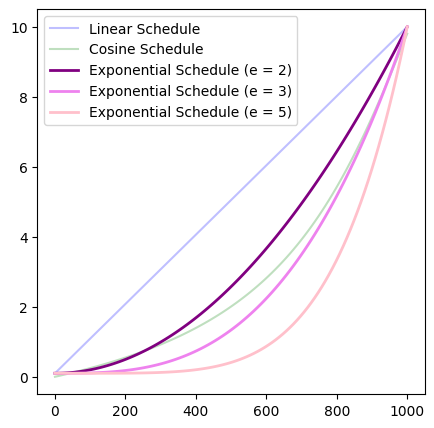

In [58]:
max_t = 1000.0
beta_max = 10.0
x = torch.linspace(0, max_t, 100)

plt.figure(figsize=(5, 5))

lin_schedule = LinearNoiseSchedule(max_t=max_t, beta_max=beta_max)
plt.plot(x, lin_schedule(x), label='Linear Schedule', color='blue', alpha=0.25)

cos_schedule = CosineNoiseSchedule(max_t=max_t, beta_max=beta_max)
plt.plot(x, cos_schedule(x), label='Cosine Schedule', color='green', alpha=0.25)

exp_schedule = ExponentialNoiseSchedule(max_t=max_t, beta_max=beta_max, e=2.0)
plt.plot(x, exp_schedule(x), label='Exponential Schedule (e = 2)', color='purple', linewidth=2)

exp_schedule = ExponentialNoiseSchedule(max_t=max_t, beta_max=beta_max, e=3.0)
plt.plot(x, exp_schedule(x), label='Exponential Schedule (e = 3)', color='violet', linewidth=2)

exp_schedule = ExponentialNoiseSchedule(max_t=max_t, beta_max=beta_max, e=5.0)
plt.plot(x, exp_schedule(x), label='Exponential Schedule (e = 5)', color='pink', linewidth=2)

plt.legend()
plt.show()